In [1]:
import numpy as np
import pandas as pd
import os
import re
import random
import gc
import pydicom as pdc
from utils.datahandling_utils import createImageArray


In [2]:
SEED = 41
BATCH_SIZE = 64
random.seed(SEED)


In [2]:
label_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
image_path = "D:/iCAT_IMAGES"


In [3]:
data = pd.read_csv("./data_indexes/data_indices.csv", ",", index_col=0)
data = data.sort_values(["Patient", "Volume", "Slice"], ignore_index=True)


C:\Users\svenalrik\AppData\Local\Temp\ipykernel_12296\1823079287.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv("./data_indexes/data_indices.csv", ",", index_col=0)


In [4]:
def crop_image(image: np.ndarray, reduction: float = 0.70):
    y_bottom, y_top = int(
        image.shape[0]*reduction), int(image.shape[0]*(1-reduction))
    return image[y_top:y_bottom, y_top:y_bottom]


In [21]:
patient = data.loc[(data['Patient'] == 36) & (
    data['Slice'] == 20) & (data['Volume'] == 13)]
dcm = pdc.read_file(patient['ImagePath'].item()).pixel_array
# dcm = pdc.read_file("D:/sailor_DCE/027/01/DCE/10.dcm").pixel_array

reduction: float = 0.70
y_bottom, y_top = int(dcm.shape[0]*reduction), int(dcm.shape[0]*(1-reduction))
dcm_crop = dcm[y_top:y_bottom, y_top:y_bottom]
print(f"Image dimensions reduced from {dcm.shape} to {dcm_crop.shape}")


Image dimensions reduced from (160, 160) to (64, 64)


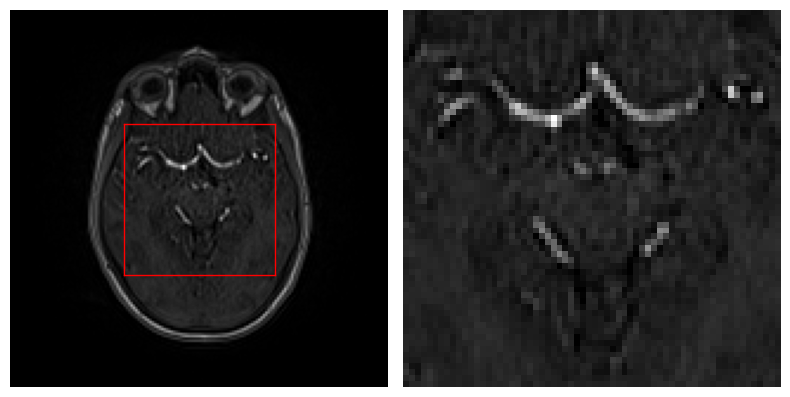

In [22]:
import matplotlib.pyplot as plt
import matplotlib.lines as line
fig, axs = plt.subplots(1, 2, figsize=(8, 10))
axs[0].imshow(dcm, cmap='gray')
axs[0].add_artist(line.Line2D([y_bottom, y_bottom], [
                  y_top, y_bottom], color='red', linewidth=1))  # Høyre
axs[0].add_artist(line.Line2D([y_top, y_top], [y_top, y_bottom],
                  color='red', linewidth=1))       # Venstre
axs[0].add_artist(line.Line2D([y_bottom, y_top], [y_top, y_top],
                  color='red', linewidth=1))       # Topp
axs[0].add_artist(line.Line2D([y_bottom, y_top], [
                  y_bottom, y_bottom], color='red', linewidth=1))  # Bunn
axs[0].axis('off')
axs[1].imshow(dcm_crop, cmap='gray')
axs[1].axis('off')
fig.tight_layout()


In [ ]:
dcm = pdc.read_file("D:/sailor_DCE/027/01/DCE/10.dcm").keys()


NameError: name 'pdc' is not defined